Back in 2010 Rajarshi Guha [blogged](http://blog.rguha.net/?p=850) about converting the [PAINS substructure filters](http://dx.doi.org/10.1021/jm901137j) from [SLN](http://pubs.acs.org/doi/abs/10.1021/ci960109j) to SMARTS. Given the paucity of tools that effectively support SLN and the usefulness of the PAINS filters, these SMARTS patterns really caught on. Rajarshi ended up also publishing [a paper](http://doi.wiley.com/10.1002/minf.201100076) together with J. Baell, one of the original authors of the PAINS paper, that provided KNIME workflows for using the RDKit and Indigo to filter PAINS compounds. A big focus of the paper was differences in the number of matches provided by the two toolkits. The RDKit matched a lot less structures than Indigo did, but neither matched as many as expected.

With the advent of the [FilterCatalog functionality](https://github.com/rdkit/rdkit/pull/536) in the RDKit, we included the "standard" SMARTS version of PAINS. Axel Pahl quickly [pointed out](https://github.com/rdkit/rdkit/pull/536#issuecomment-123706922) some problems that he had experienced using the PAINS filters and the RDKit. Axel also pointed out that we really didn't have a good test set for the filters.

This all led me to spend some time looking at the SMARTS versions of the PAINS filters and the way the RDKit handles them. It's fortunate that I had a good-sized block of time, because this turned into a larger task than I had anticipated. I ended up making a number of improvements to the ways Hs from SMARTS are handled, fixing [some](https://github.com/rdkit/rdkit/issues/544) [bugs](https://github.com/rdkit/rdkit/issues/557), and modifying a lot of the PAINS SMARTS definitions. This required a bunch of iterative tweaking and testing that I won't describe in detail here, but I think it's worthwhile getting into a bit of what I did and why the changes were necessary.

An aside here: SLN is an interesting format that never really caught on. This set provides a good opportunity for testing and refining the RDKit's SLN support, which has been there for a while at least for standard molecules, but is not extensively tested and would need to be extended to support more query features.

In [1]:
from rdkit import Chem
import time,random
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = (450,250)
from rdkit import rdBase
from __future__ import print_function
%load_ext sql
print(rdBase.rdkitVersion)
print(time.asctime())

2015.09.1.dev1
Sun Aug  9 15:04:15 2015


## H atoms in SMARTS

In order for any of this to make sense, it's first important to understand what the RDKit does with H atoms in SMARTS.

Here's one of the SMARTS from the PAINS set:

```"[#8]=[#16](=[#8])-[#6](-[#6]#[#7])=[#7]-[#7]-[#1]","<regId=cyano_imine_C(12)>"```

Here's a rendering of the pattern:

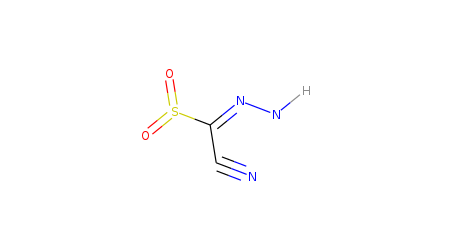

In [2]:
sma = '[#8]=[#16](=[#8])-[#6](-[#6]#[#7])=[#7]-[#7]-[#1]'
pains8 = Chem.MolFromSmarts(sma)
pains8

And a molecule that should match:

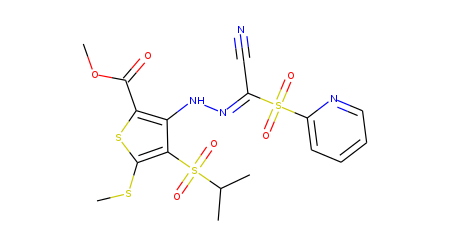

In [3]:
mol8 = Chem.MolFromSmiles(r'COC(=O)c1sc(SC)c(S(=O)(=O)C(C)C)c1N/N=C(\C#N)S(=O)(=O)c1ccccn1') #CHEMBL3211428
mol8

Though we can clearly see that there should be a substructure match, we don't get one:

In [5]:
mol8.HasSubstructMatch(pains8)

False

The problem is that explicit H in the SMARTS. In order to get a match we need to either add hydrogens:

In [6]:
mol8h = Chem.AddHs(mol8)
mol8h.HasSubstructMatch(pains8)

True

or merge the H atom into the atom it's attached to:

In [7]:
pains8h = Chem.MergeQueryHs(pains8)
mol8.HasSubstructMatch(pains8h)

True

It's important to note that this still matches the molecule with Hs:

In [8]:
mol8h.HasSubstructMatch(pains8h)

True

So what did this do to the query?

In [9]:
Chem.MolToSmarts(pains8h)

'[#8]=[#16](=[#8])-[#6](-[#6]#[#7])=[#7]-[#7&!H0]'

`MergeQueryHs()` finds explicit H atom queries and merges them with the query on the attached atom to add an hydrogen count query. In this case it's specified that the nitrogen has at least one H atom.

The handling of explicit Hs in queries was, I suspect a large part of the reason that the RDKit didn't generate many matches in the [KNIME PAINS paper](http://doi.wiley.com/10.1002/minf.201100076): 391 of the 480 PAINS SMARTS patterns contain an explicit H atom or an explicit H as part of an atom query. Some of those would still generate matches, but many would not.

I'll show a few more examples of how the merging works. Rather than using `MergeQueryHs()` explicitly in these examples, I will tell the RDKit to perform the merge as part of building the molecule from the SMARTS using the `mergeHs` argument to `MolFromSmartS()`:

In [11]:
patt = Chem.MolFromSmarts('[#6]([#1])[#1]',mergeHs=True)
Chem.MolToSmarts(patt)

'[#6&!H0&!H1]'

The code can handle recursive SMARTS properly:

In [14]:
patt = Chem.MolFromSmarts('[$([#6]-[#7]),$([#6]-[#1]),$([#6])]',mergeHs=True)
Chem.MolToSmarts(patt)

'[$([#6]-[#7]),$([#6&!H0]),$([#6])]'

But there's nothing it can do about OR queries (this is a solvable problem but the logic is complex, [here's the bug](https://github.com/rdkit/rdkit/issues/558)):

In [15]:
patt = Chem.MolFromSmarts('[#6]-[#1,#6]',mergeHs=True)
Chem.MolToSmarts(patt)

'[#6]-[#1,#6]'

While fixing the PAINS SMARTS definitions (see below) I worked around this shortcoming in the current version of the code by manually editing the affected SMARTS, so something like the above example would become:
`[#6;!H0,$([#6]-#6])]`

## Back to the PAINS

The `SLN->SMARTS` translation that Rajarshi did resulted in SMARTS that contain explicit Hs. So in order to have the PAINS be useful, I needed to make sure that the H merging was working as well as possible and that 

The first step in testing and cleaning up the SMARTS was to find molecules that match when explicit Hs are present, but which don't match when the Hs are implicit. Here's some code I used for doing that:
```
print("   reading patts")
smas = [x[0] for x in csv.reader(open('./wehi_pains.csv'))]
opatts = [Chem.MolFromSmarts(x,mergeHs=False) for x in smas]
patts = [Chem.MolFromSmarts(x,mergeHs=True) for x in smas]

print("   reading mols")
smis = [x[0] for x in csv.reader(open('./test_data/wehi_mols.csv'))]
ms = [Chem.MolFromSmiles(x) for x in smis]
mhs = [Chem.AddHs(x) for x in ms]

print("   filtering")
matches=[]
found=0
for i,(m,mh) in enumerate(zip(ms,mhs)):
    for j,(patt,opatt) in enumerate(zip(patts,opatts)):
        t1 = m.HasSubstructMatch(patt)
        t2 = mh.HasSubstructMatch(opatt)
        if t1:
            found+=1        
        if t1^t2:
            matches.append((i,j,smis[i],smas[j]))
            print(i,j,smis[i],smas[j])
    if not (i+1)%100:
        print("    Done: ",i+1," matches: ",len(matches)," found: ",found)
print("    Done: ",i+1," matches: ",len(matches)," found: ",found)
```
The idea is simple: find cases where one form of the pattern matches and the other doesn't.

Starting from the SMARTS definitions and 10K test molecules provided as part of the [KNIME PAINS paper](http://doi.wiley.com/10.1002/minf.201100076) I did a number of passes of pattern-tweaking and bug-fixing until the above code produced no matches.

The next step, more time consuming, was to repeat the process for a larger set of molecules: the 1.4 million molecules in the [ChEMBL20 SDF](ftp://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/releases/chembl_20/chembl_20.sdf.gz). 

At this point I had a set of SMARTS definitions that produced the same results as on molecules without Hs as the original SMARTS did for molecules with Hs. This had been tested on ChEMBL20 and the 10K test compounds.

## Producing a test set

Another nice thing to have would be a test set for the PAINS filters: a set of molecules where we know which PAINS filters they should match (and which they should *not* match!).

Building a good test set is hard and takes more time than I had available, but I wanted to get a start on it by finding at least one molecule that matched each of the PAINS filters.

I started using the 10K test molecules and ChEMBL20. The 10K set produced matches for 144 PAINS, ChEMBL produced matches for 293. Taking duplicates into account I now had examples for 309 of 480 PAINS. Running the set I now had across around 16 million compounds from the [ZINC full set](http://zinc.docking.org/db/bysubset/6/6_p0.smi.gz) turned up another 106 matches, bringing the total to 399; 81 to go!

I figured my best bet to get the remaining 81 was PubChem, but I really didn't feel like pulling down the full set of 40+ million compounds and processing it. So I opted to use the PubChem web services API. Here's a bit of the code I used for that:
```
import urllib,requests,json
base = 'http://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/fastsubstructure/smarts/%s/property/CanonicalSmiles/json'
pubchem={}
for key in missing_keys2:
    sma = smas[key]
    url = base%urllib.quote(sma)
    print(sma)
    try:
        r = requests.post(url)
        pubchem[key]=json.loads(r.text)
    except KeyboardInterrupt:
        break
    except:
        import traceback
        traceback.print_exc()
```

This returned matches that led to [another round of SMARTS editing](https://github.com/rdkit/rdkit/commit/e916171537a78c046a89f801ecbb030cc979314a), most of which were due to differences in aromaticity models. After finishing the process, I had examples for an additional 63 SMARTS where the RDKit could generate matches. There are 18 left that I still don't have a working example for:
```
"[#8]-[#6](=[#8])-[#6](-[#1])(-[#1])-[#16;X2]-[#6](=[#7]-[#6]#[#7])-[#7](-[#1])-c:1:c:c:c:c:c:1","<regId=cyanamide_A(1)>"
"c:1-3:c(:c:c:c:c:1)-[#16]-[#6](=[#7]-[#7]=[#6]-2-[#6]=[#6]-[#6]=[#6]-[#6]=[#6]-2)-[#7]-3-[#6](-[#1])-[#1]","<regId=colchicine_het(1)>"
"c:1(:c(:c:2:c(:n:c:1-[#7](-[#1])-[#1]):c:c:c(:c:2-[#7](-[#1])-[#1])-[#6]#[#7])-[#6]#[#7])-[#6]#[#7]","<regId=cyano_amino_het_A(1)>"
"[#6](-[#1])-[#6]:2:[#7]:[#7](-c:1:c:c:c:c:c:1):[#16]:3:[!#6&!#1]:[!#1]:[#6]:[#6]:2:3","<regId=het_thio_N_55(5)>"
"[#6]-2(=[#16])-[#7]-1-[#6]:[#6]-[#7]=[#7]-[#6]-1=[#7]-[#7]-2-[#1]","<regId=thio_urea_K(2)>"
"[#7](-[#1])(-[#1])-c:1:c(:c(:c(:c(:c:1-[#7](-[#1])-[#16](=[#8])=[#8])-[#1])-[#7](-[#1])-[#6](-[#1])-[#1])-[F,Cl,Br,I])-[#1]","<regId=anil_NH_no_alk_B(1)>"
"[#7]-4(-c:1:c:c:c:c:c:1)-[#6](=[#7+](-c:2:c:c:c:c:c:2)-[#6](=[#7]-c:3:c:c:c:c:c:3)-[#7]-4)-[#1]","<regId=het_5_inium(1)>"
"c:1:3:c(:c:c:c:c:1)-[#7]-2-[#6](=[#8])-[#6](=[#6](-[F,Cl,Br,I])-[#6]-2=[#8])-[#7](-[#1])-[#6]:[#6]:[#6]:[#6](-[#8]-[#6](-[#1])-[#1]):[#6]:[#6]:3","<regId=anil_OC_alk_B(3)>"
"[#6]-1(=[#6](-!@[#6]=[#7])-[#16]-[#6](-[#7]-1)=[#8])-[$([F,Cl,Br,I]),$([#7+](:[#6]):[#6])]","<regId=thiaz_ene_C(11)>"
"s:1:c(:c(-[#1]):c(:c:1-[#6]-3=[#7]-c:2:c:c:c:c:c:2-[#6](=[#7]-[#7]-3-[#1])-c:4:c:c:n:c:c:4)-[#1])-[#1]","<regId=het_76_A(1)>"
"[#7]=[#6]-1-[#7](-[#1])-[#6](=[#6](-[#7]-[#1])-[#7]=[#7]-1)-[#7]-[#1]","<regId=het_6_imidate_A(4)>"
"[#6]-2(=[#7]-c1c(c(nn1-[#6](-[#6]-2(-[#1])-[#1])=[#8])-[#7](-[#1])-[#1])-[#7](-[#1])-[#1])-[#6]","<regId=het_65_G(1)>"
"c:1:2(:c(:c(:c(:o:1)-[#6])-[#1])-[#1])-[#6](=[#8])-[#7](-[#1])-[#6]:[#6](-[#1]):[#6](-[#1]):[#6](-[#1]):[#6](-[#1]):[#6]:2-[#6](=[#8])-[#8]-[#1]","<regId=anthranil_acid_I(1)>"
"[#6](-[#1])(-c:1:c(:c(:c(:c(:c:1-[#1])-[#1])-[Cl])-[#1])-[#1])(-c:2:c(:c(:c(:c(:c:2-[#1])-[#1])-[Cl])-[#1])-[#1])-[#8]-[#6](-[#1])(-[#1])-[#6](-[#1])(-[#1])-[#6](-[#1])(-[#1])-c3nc(c(n3-[#6](-[#1])(-[#1])-[#1])-[#1])-[#1]","<regId=misc_imidazole(1)>"
"c2(c-1n(-[#6](-[#6]=[#6]-[#7]-1)=[#8])nc2-c3cccn3)-[#6]#[#7]","<regId=het_65_H(1)>"
"[#7](-[#1])(-c:1:c(:c(:c(:c(:c:1-[#1])-[#1])-[#1])-[#1])-[#8]-[#1])-[#6]-2=[#6](-[#8]-[#6](-[#7]=[#7]-2)=[#7])-[#7](-[#1])-[#1]","<regId=het_6_imidate_B(1)>"
"[#8]=[#6]-3-c:1:c(:c:c:c:c:1)-[#6]-2=[#6](-[#8]-[#1])-[#6](=[#8])-[#7]-c:4:c-2:c-3:c:c:c:4","<regId=quinone_C(2)>"
"c:1:c:c-2:c(:c:c:1)-[#7](-[#6](-[#8]-[#6]-2)(-[#6](=[#8])-[#8]-[#1])-[#6](-[#1])-[#1])-[#6](=[#8])-[#6](-[#1])-[#1]","<regId=misc_aminal_acid(1)>"
```

These, along with having a set of molecules which are known *not* to match each PAINS, and looking into the aromaticity model changes in some more detail, are things to come back to. In the meantime, the test set, along with code that runs it, is here: https://github.com/rdkit/rdkit/tree/master/Data/Pains/test_data
The updated version of the PAINS filters is here:
https://github.com/rdkit/rdkit/blob/master/Data/Pains/wehi_pains.csv

A request: getting this put together was a fair amount of work and it would be very nice to get some feedback on it/credit for it. If you use these, please let me know either via email, posts to the mailing list, a comment here, or a message on github. The data files and tests are under the same BSD license as the rest of the RDKit, so there's no requirement that you do so, but it would be a nice gesture. :-)

